# Query for Spectraction Results in OGA

 work with Weakly_2023_01
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2022/10/31
- last update : 2023/01/20


In [1]:
! eups list -s | grep LOCAL

atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_01/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-5.1.0/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2023_01/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g754a7f0350+935911ccad 	current w_2023_01 setup


In [3]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
import pickle

In [6]:
from astropy.time import Time
import astropy.units as u

## Config

### Butler

In [7]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

### Date & Filter & Disperser

In [8]:
# path index for each month
#DATE="20220912"
#DATE="20220913"
DATE="20230117"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"

### Spectractor

In [9]:
configmode = "PSF2DFFM_REBIN2"

### The collection

In [10]:
#my_collection = "u/dagoret/spectro/noflat/empty~holo4/"+str(DATE)
#my_collection = "u/dagoret/BPS_manyspectro_v0" # january 12th 2023
my_collection = "u/dagoret/BPS_manyspectro_v7" # january 20th 2023
datasetRefs = registry.queryDatasets(datasetType='spectraction', collections=my_collection, where= "instrument='LATISS'")

In [11]:
# following line not possible in OGA
#butler = butlerUtils.makeDefaultLatissButler(extraCollections=[my_collection])

## Loop on exposures

In [12]:
all_dataId = []     # full data id
all_spec = []       # spectra
all_exposures = []  # exposure number
all_num = []        # sequence numbers



for i, ref in enumerate(datasetRefs):

    print(f"============= ({i}) ============datasetType = spectraction ============================================")
    print("fullId..................:",ref.dataId.full)
    print("visit...................:",ref.dataId["visit"])
    print("band....................:",ref.dataId["band"])
    print("physical filter.........:",ref.dataId["physical_filter"])
    print("run.....................:",ref.run)
    the_exposure = ref.dataId["visit"]
    the_day_obs = ref.dataId["visit"]//100_000
    the_seq_num = ref.dataId["visit"]- the_day_obs*100_000    
    the_dataId = {'day_obs': the_day_obs,'seq_num':the_seq_num,'detector':0}
    print(the_dataId)
    
    # retrieve the spectrum from Butler
    #spec       = butler.get('spectraction',the_dataId)
    spec = butler.get('spectraction', visit=the_exposure, detector=0, collections=my_collection, instrument='LATISS')
    
    # save in collection lists
    all_dataId.append(the_dataId) 
    all_exposures.append(the_exposure)
    all_spec.append(spec)
    all_num.append(the_seq_num)
    
    if i>14:
        break
          


============= (0) ============datasetType = spectraction ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', visit: 2023011700240}
visit...................: 2023011700240
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/BPS_manyspectro_v7/20230119T075407Z
{'day_obs': 20230117, 'seq_num': 240, 'detector': 0}
============= (1) ============datasetType = spectraction ============================================
fullId..................: {band: 'white', instrument: 'LATISS', detector: 0, physical_filter: 'empty~holo4_003', visit: 2023011700688}
visit...................: 2023011700688
band....................: white
physical filter.........: empty~holo4_003
run.....................: u/dagoret/BPS_manyspectro_v7/20230119T075407Z
{'day_obs': 20230117, 'seq_num': 688, 'detector': 0}
============= (2) ============datasetType = spec

## Plot

 >>> Exception catched for 0):2023011700240
<class 'ValueError'>
("'yerr' must not contain negative values",)
 >>> Exception catched for 10):2023011700604
<class 'ValueError'>
("'yerr' must not contain negative values",)
 >>> Exception catched for 11):2023011700453
<class 'ValueError'>
("'yerr' must not contain negative values",)


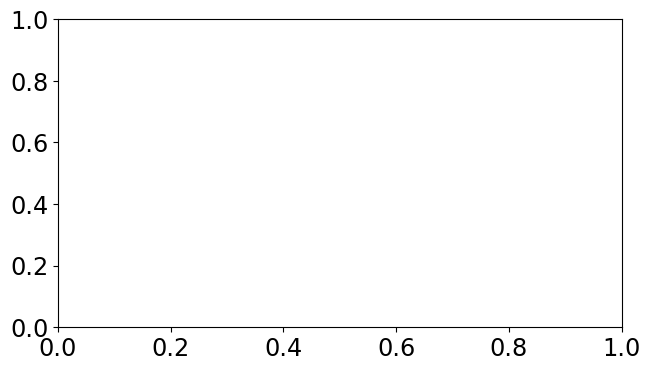

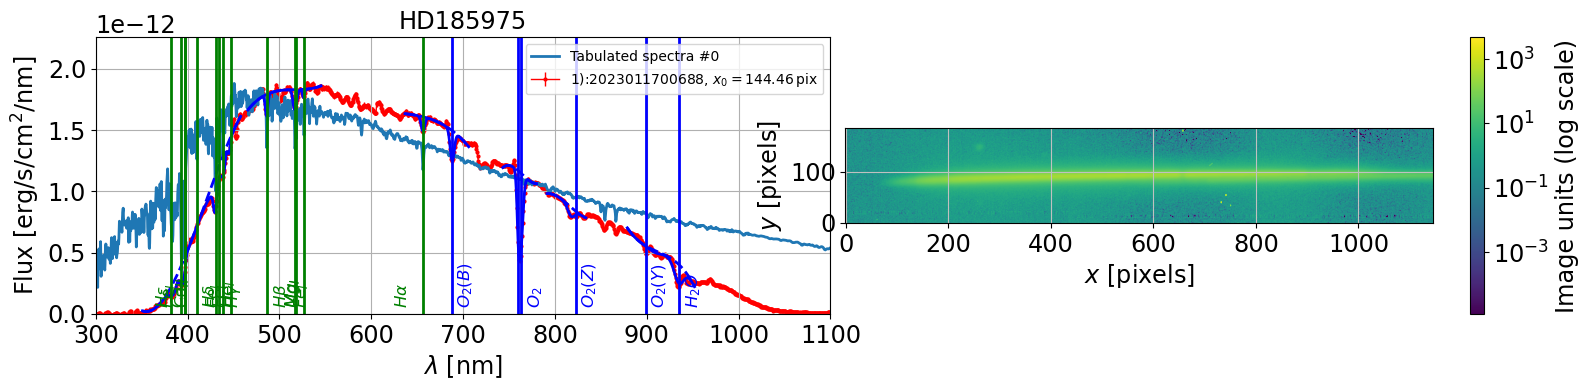

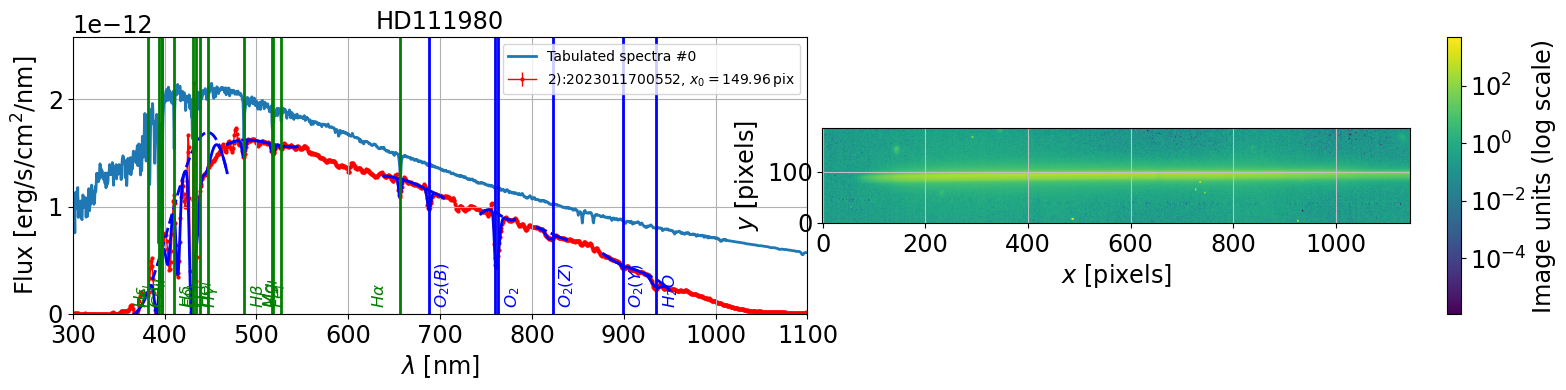

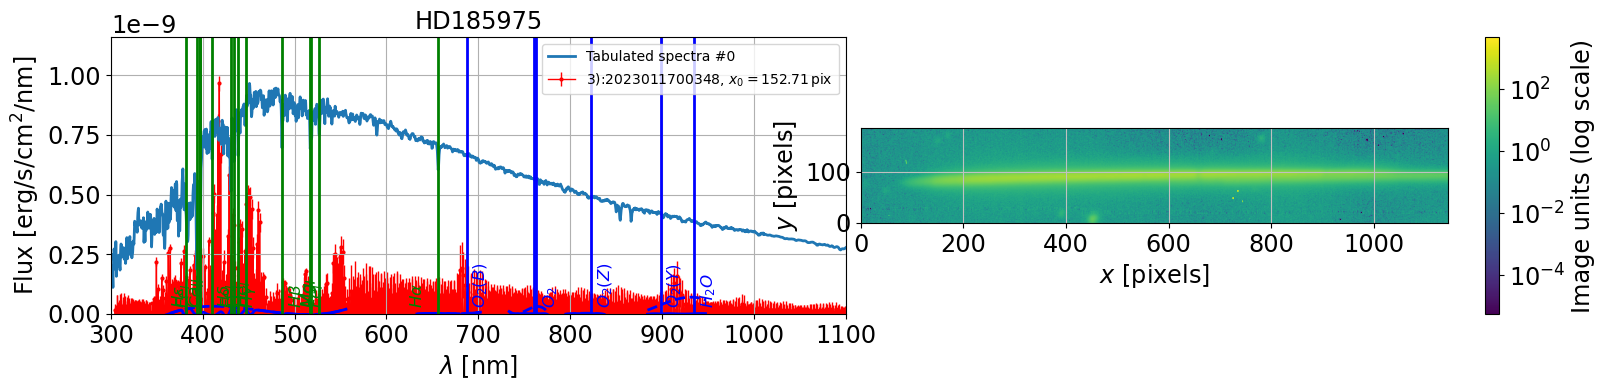

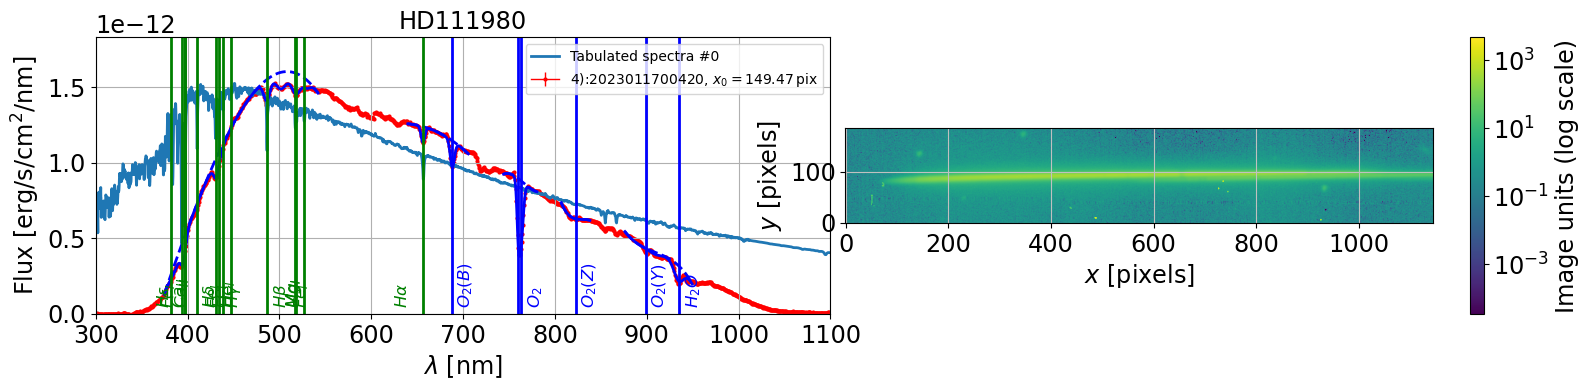

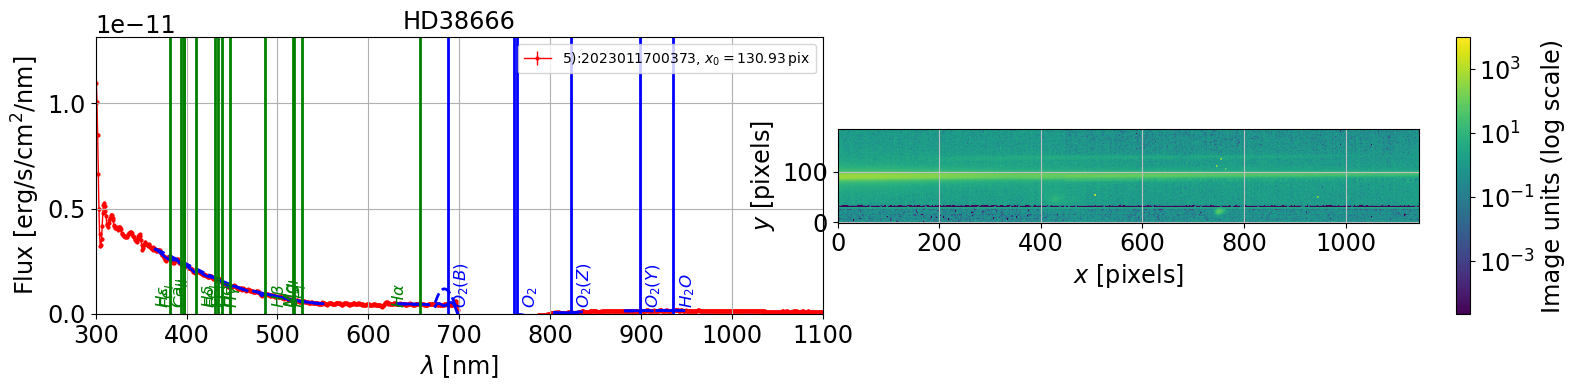

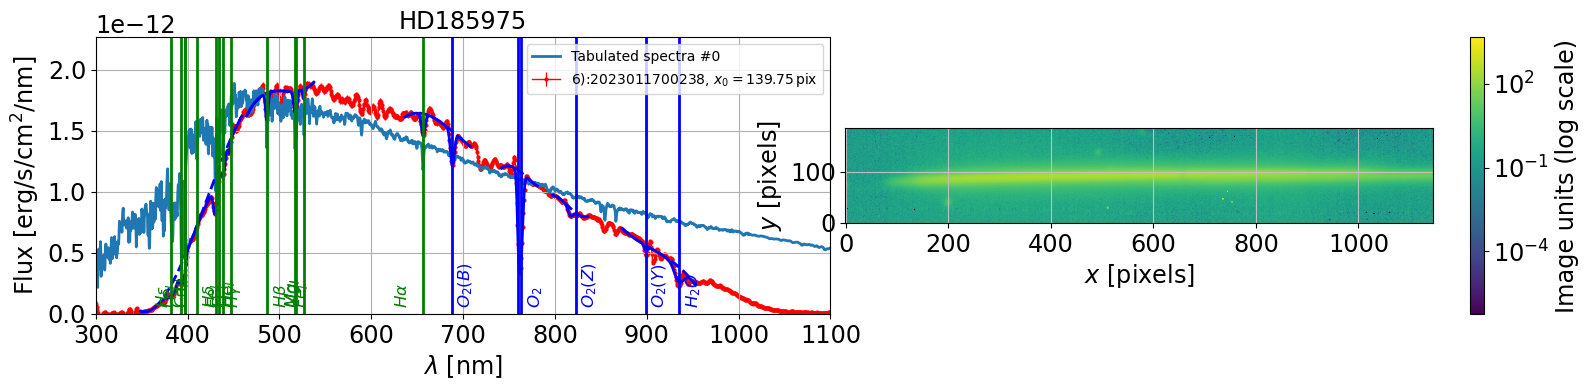

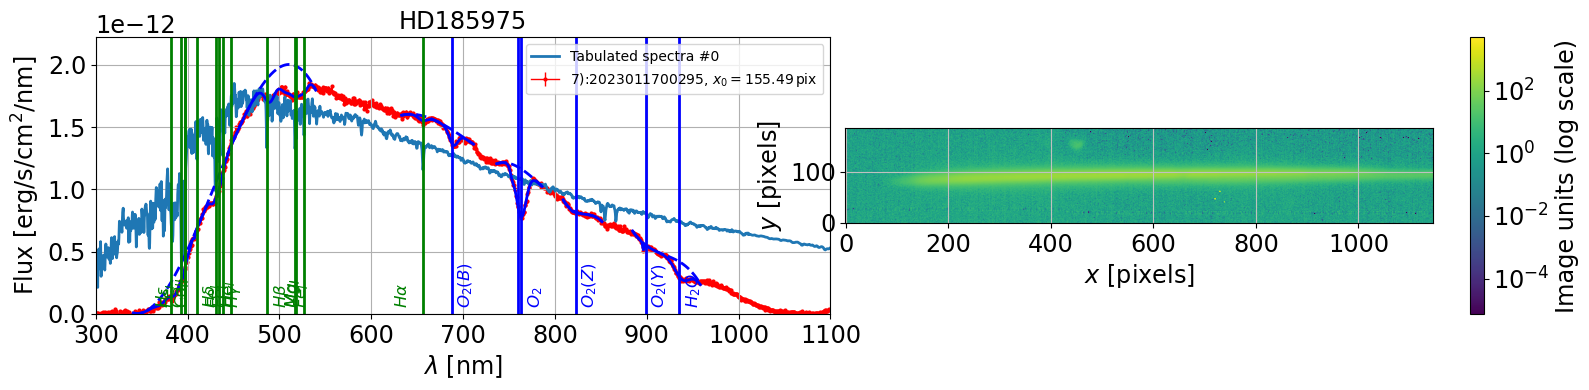

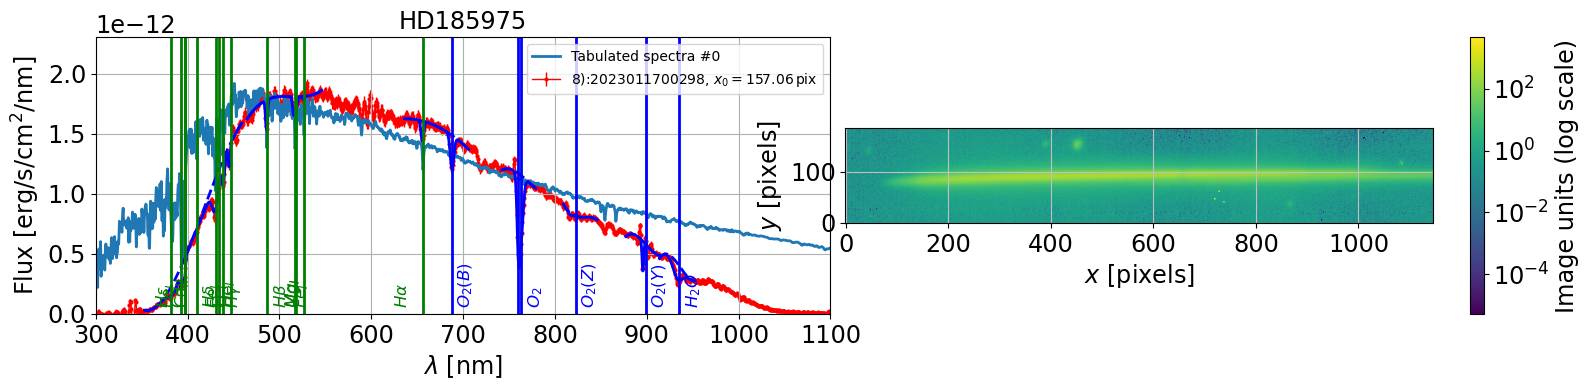

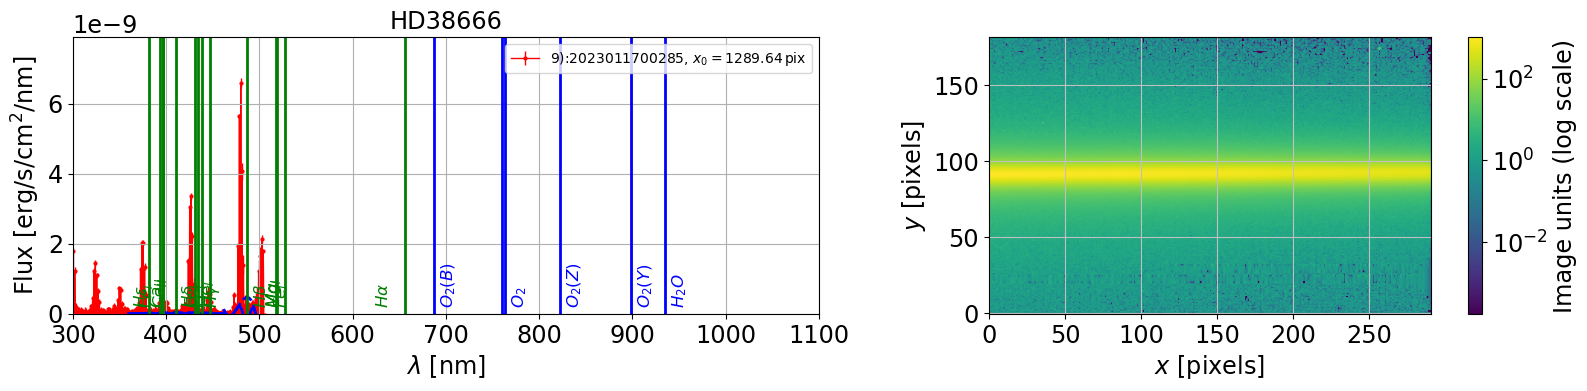

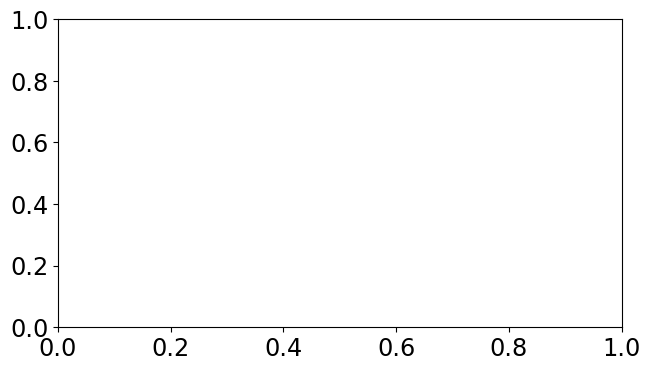

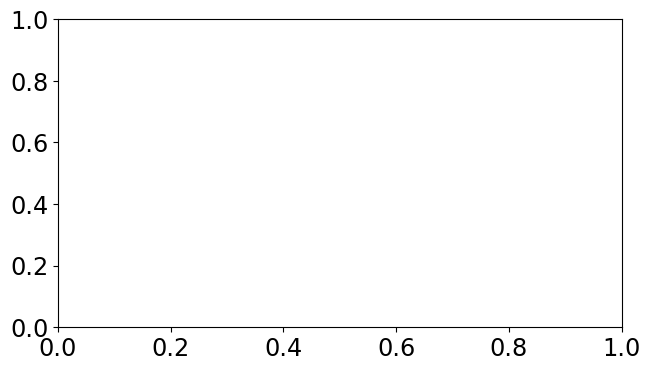

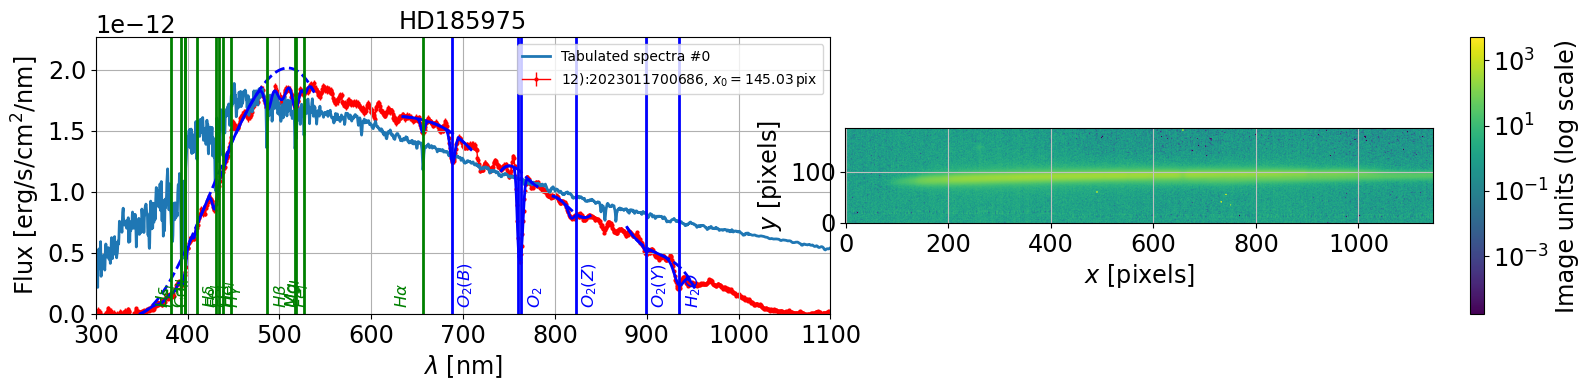

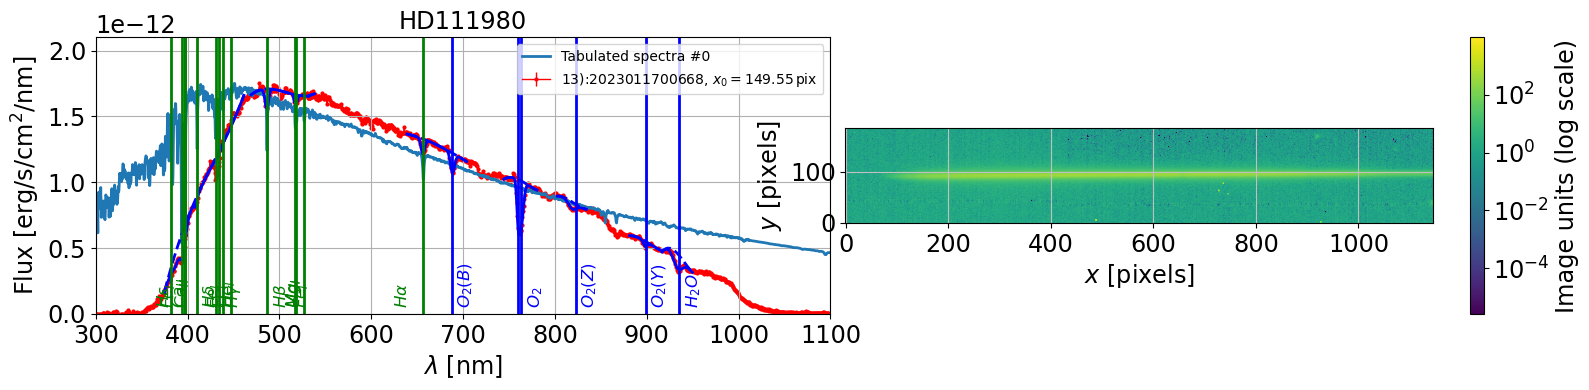

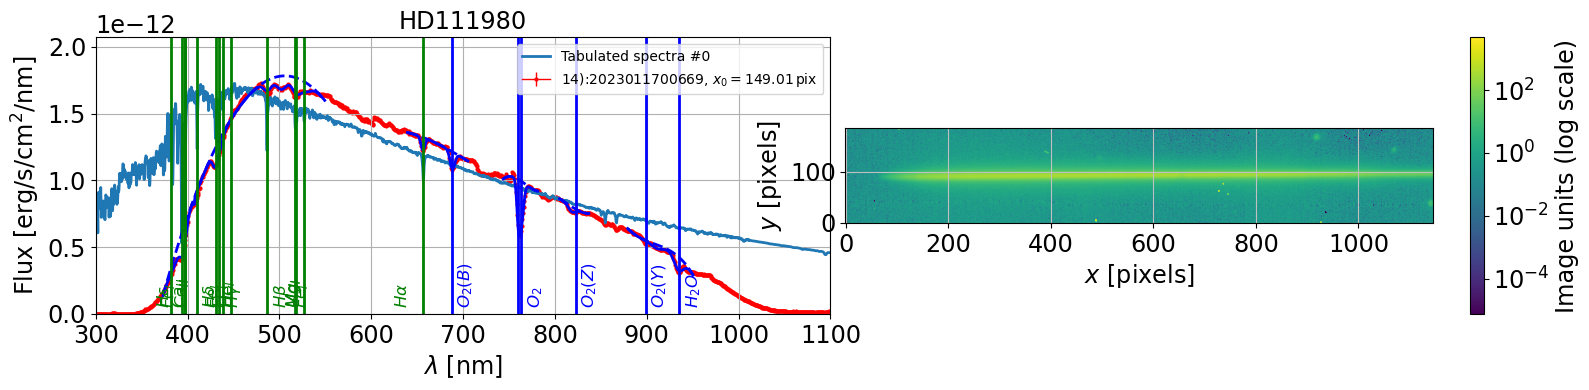

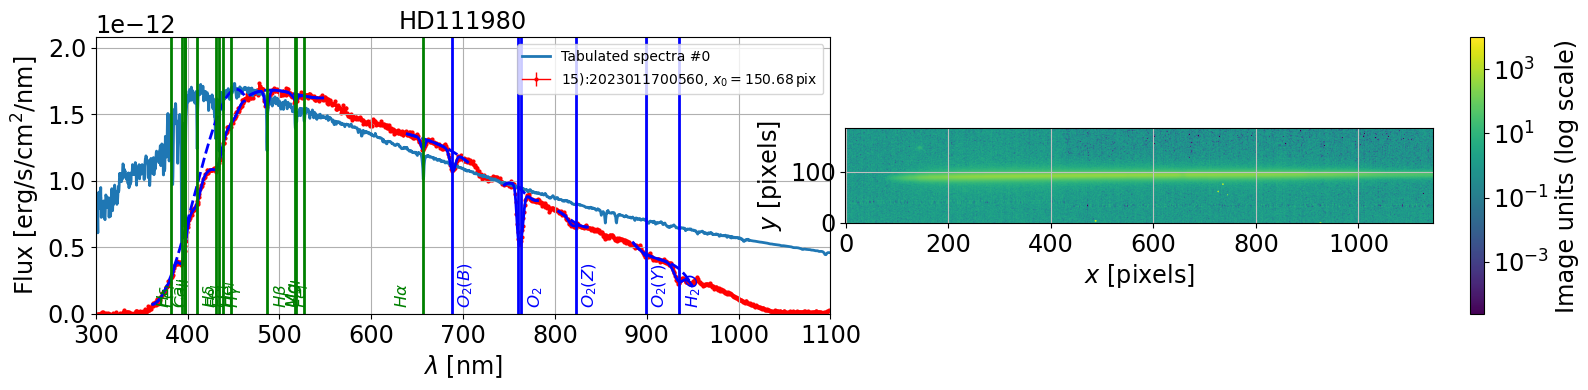

In [13]:
%matplotlib inline

FLAG_ORDER2 = False

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]

if FLAG_ORDER2:
    all_lambdas_order2=[]
    all_data_order2=[]
    all_data_err_order2=[]


idx=0
for spec in all_spec:
    
    
    s=spec.spectrum
    label = str(idx) +"):" + str(all_exposures[idx])
    
    try:
        fig=plt.figure(figsize=(16,4))
    
        ax1 = fig.add_subplot(1, 2, 1)
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
        ax2 = fig.add_subplot(1, 2, 2)
        s.plot_spectrogram(ax=ax2,scale="log")
    
        all_lambdas.append(s.lambdas)
        all_data.append(s.data)
        all_data_err.append(s.err)
    
        if FLAG_ORDER2:
            all_lambdas_order2.append(s.lambdas_order2)
            all_data_order2.append(s.data_order2)
            all_data_err_order2.append(s.err_order2)
            
        #save info    
        infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
            
    except Exception as inst:
        print(" >>> Exception catched for "+ label )
        print(type(inst))    # the exception instance
        print(inst.args)     # arguments stored in .args

    
        
    #infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    idx+=1

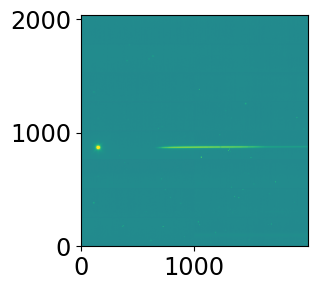

In [14]:
plt.imshow(spec.image.data-spec.image.data.min(),origin="lower",norm=LogNorm(vmin=1,vmax=1000))

# Generate info

In [15]:
df_infos=pd.DataFrame(infos,columns=["idx","object","date_obs","airmass","temperature","pressure","humidity"])

In [16]:
df_infos.set_index('idx',inplace=True)

In [17]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [18]:
all_reftime=np.array(all_reftime)

In [19]:
df_infos["reftime"]=all_reftime

In [20]:
NN = len(df_infos)

In [21]:
df_infos

,object,date_obs,airmass,temperature,pressure,humidity,reftime
idx,,,,,,,
0,HD074000,2023-01-18T02:42:42.728506021Z,1.339617,0,0,0,0.000000
1,HD185975,2023-01-18T08:48:52.932497300Z,2.083472,0,0,0,6.102834
2,HD111980,2023-01-18T07:06:10.745990322Z,1.274201,0,0,0,4.391116
3,HD185975,2023-01-18T04:27:59.378503148Z,2.137054,0,0,0,1.754625
4,HD111980,2023-01-18T05:33:35.532999304Z,1.900491,0,0,0,2.848001
5,HD38666,2023-01-18T04:49:43.535998322Z,1.127205,0,0,0,2.116891
6,HD185975,2023-01-18T02:33:44.320492641Z,2.094160,0,0,0,-0.149558
7,HD185975,2023-01-18T03:47:41.739007940Z,2.125845,0,0,0,1.083058
8,HD185975,2023-01-18T03:49:13.267493074Z,2.126274,0,0,0,1.108483


### Save info file

In [22]:
summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configmode}-oga.csv"
df_infos.to_csv(summary_file)

## Main pickle file

In [23]:
#spec.image.target_pixcoords

In [24]:
header = spec.spectrum.header
header

SIMPLE  =                    T                                                  
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1146                                                  
NAXIS2  =                    3                                                  
EXTEND  =                    T                                                  
TARGET  = 'HD111980'           / name of the target in the image                
REDSHIFT=             0.000517 / redshift of the target                         
GRATING = 'holo4_003'          / name of the disperser                          
ROTANGLE=   0.2788857912871391 / [deg] angle of the dispersion axis             
D2CCD   =    180.0742757953202 / [mm] distance between disperser and CCD        
LSHIFT  =                  0.0                                                  
PARANGLE=   -115.95664926309

In [25]:


all_rebin=np.zeros(NN)
all_targetx=np.zeros(NN)
all_targety=np.zeros(NN)
all_rotangle=np.zeros(NN)
all_d2ccd=np.zeros(NN)
all_pixshift=np.zeros(NN)
all_chi2_fit=np.zeros(NN)
all_a2_fit=np.zeros(NN)
all_lbda_ref=np.zeros(NN)
all_tagnumber=np.zeros(NN)
all_errors=np.zeros(NN)


for idx in range(NN):
    
    header = all_spec[idx].spectrum.header
    tagnum=str(all_num[idx])
    
    #ROTANGLE=  -0.1367006901184345 / [deg] angle of the dispersion axis             
    #D2CCD   =    179.6778868175837 / [mm] distance between disperser and CCD        
    #TARGETX =    315.9547462941386 / target position on X axis                      
    #TARGETY =    75.06785960446246 / target position on Y axis                      
    #LBDA_REF=    634.9155139280113                                                  
    #PIXSHIFT=  -0.9996981508176748                                                  
    #CHI2_FIT=    1.602115867259752                                                  
    #A2_FIT  =                  1.0                                                  
    #REBIN   =                    2 / original image rebinning factor to get spectrum
    
    try :
        rebin=header["REBIN"]
    except KeyError as e:
        rebin=2
        all_errors[idx]=1
        print(f"KeyError exception for spec {idx}: " + str(e) + f" ! ==> force rebin = {rebin}")
        
        
        
    targetx=header["TARGETX"]*rebin
    targety=header["TARGETY"]*rebin
    rotangle=header["ROTANGLE"]
    d2ccd=header["D2CCD"]
    pixshift=header["PIXSHIFT"]
    
    if header.get("CHI2_FIT") != None:
        chi2_fit=header["CHI2_FIT"]
    else:
        chi2_fit= -1
        
    if header.get("A2_FIT") != None:
        a2_fit=header["A2_FIT"]
    else:
        a2_fit=-1
    
    
    lbda_ref=header["LBDA_REF"]
    
    
    all_rebin[idx]=rebin
    all_targetx[idx]=targetx
    all_targety[idx]=targety
    all_rotangle[idx]=rotangle
    all_d2ccd[idx]=d2ccd
    all_pixshift[idx]=pixshift
    
    
    all_chi2_fit[idx]=chi2_fit
    all_a2_fit[idx]=a2_fit
    all_lbda_ref[idx]=lbda_ref
    all_tagnumber[idx]=tagnum
    


KeyError exception for spec 1: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 4: "Keyword 'REBIN' not found." ! ==> force rebin = 2
KeyError exception for spec 5: "Keyword 'REBIN' not found." ! ==> force rebin = 2


KeyError: "Keyword 'LBDA_REF' not found."

## Write pickle file

In [ ]:
all_out_data = {}

for idx in range(NN):
    if FLAG_ORDER2:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'], 
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'error':all_errors[idx],    
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
               'all_lambdas_order2':all_lambdas_order2[idx],
               'all_fluxes_order2':all_data_order2[idx],
               'all_fluxes_err_order2':all_data_err_order2[idx],
              }
    else:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'],
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'error':all_errors[idx],  
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
            }         
            
    all_out_data[all_exposures[idx]]=thedata


In [ ]:
#all_out_data

In [ ]:
pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configmode}-oga.pickle'

In [ ]:
with open(pkl_outfilename, 'wb') as pickle_file:
    pickle.dump(all_out_data,pickle_file)

In [ ]:
pkl_infilename=pkl_outfilename

In [ ]:
with open(pkl_infilename, 'rb') as pickle_file:
    content = pickle.load(pickle_file)

In [ ]:
# Get first value of dictionary
next(iter(content.items()))